## Import Libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from pprint import pprint
import os
import joblib
import yaml
import boto3
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

sns.set_style("darkgrid")
warnings.filterwarnings("ignore")

SEED = 42
ARTIFACTS_OUTPUT_PATH = os.path.join("..", "models", "artifacts")
FEATURES_OUTPUT_PATH = os.path.join("..", "models", "features")

## Data Cleaning

### Loading Dataset

In [2]:
# reading credentials files
with open("../credentials.yaml") as f:
    try:
        content = yaml.safe_load(f)
    except yaml.YAMLError as e:
        print(e)

if content["S3"] != "YOUR_S3_BUCKET_URL":
    s3 = boto3.client(
        "s3",
        aws_access_key_id=content["AWS_ACCESS_KEY"],
        aws_secret_access_key=content["AWS_SECRET_KEY"]
    )

    # downloading the original file from the aws s3 bucket
    if not os.path.exists("../data/Original_ObesityDataSet.csv"):
        s3.download_file(content["S3"], "Original_ObesityDataSet.csv", "../data/Original_ObesityDataSet.csv")

df = pd.read_csv("../data/Original_ObesityDataSet.csv", sep=",")
pprint(f"Dataset shape: {df.shape}")

'Dataset shape: (2111, 17)'


### Removing Duplicates

In [3]:
df = df.drop_duplicates(keep="first")
pprint(f"Dataset shape: {df.shape}")

'Dataset shape: (2087, 17)'


### Transforming Height Units to Centimeters

In [4]:
df["Height"] *= 100
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,162.0000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,152.0000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,180.0000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,180.0000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,178.0000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,171.0730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,174.8584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,175.2206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,173.9450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


### Removing Outliers

In [5]:
# calculating the upper and lower limits
Q1 = df["Age"].quantile(0.25)
Q3 = df["Age"].quantile(0.75)
threshold = 3.5
IQR = Q3 - Q1

pprint(f"Dataset shape before removing the outliers: {df.shape}")

# removing the data samples that exceeds the upper or lower limits
df = df[~((df["Age"] >= (Q3 + threshold * IQR)) | (df["Age"] <= (Q1 - threshold * IQR)))]
pprint(f"Dataset shape after removing the outliers: {df.shape}")

'Dataset shape before removing the outliers: (2087, 17)'
'Dataset shape after removing the outliers: (2076, 17)'


### Creating New Features

#### Body Mass Index (BMI)

In [6]:
df["BMI"] = df["Weight"] / (df["Height"] ** 2)

#### Physical Activity Level (PAL)

In [7]:
df["PAL"] = df["FAF"] - df["TUE"]

#### Body Surface Area (BSA)

In [8]:
def calculate_bsa(
    gender: str,
    height: float,
    weight: float
) -> float:
    # Schlich formula
    if gender == "Female":
        return 0.000975482 * (weight ** 0.46) * (height ** 1.08)

    return 0.000579479 * (weight ** 0.38) * (height ** 1.24)

df["BSA"] = df.apply(lambda x: calculate_bsa(x["Gender"], x["Height"], x["Weight"]), axis=1)

#### Ideal Body Weight (IBW)

In [9]:
def calculate_ibw(
    gender: str,
    height: float
) -> float:
    # B. J. Devine formula
    if gender == "Female":
        return 45.5 + 0.9 * (height - 152)

    return 50 + 0.9 * (height - 152)

df["IBW"] = df.apply(lambda x: calculate_ibw(x["Gender"], x["Height"]), axis=1)
df["diff_W_IBW"] = df["Weight"] - df["IBW"]

#### Basal Metabolic Rate (BMR)

In [10]:
def calculate_bmr(
    age: int,
    gender: str,
    height: float,
    weight: float
) -> float:
    s = -161 if gender == "Female" else 5
    return (10 * weight) + (6.25 * height) - (5 * age) + s

df["BMR"] = df.apply(lambda x: calculate_bmr(x["Age"], x["Gender"], x["Height"], x["Weight"]), axis=1)

#### Total Daily Energy Expenditure (TDEE)

In [11]:
def calculate_tdee(
    bmr: float,
    activity: float
) -> float:
    if activity == 0:
        return bmr * 1.2
    elif activity < 1:
        return bmr * 1.55
    elif activity > 1 and activity <= 2:
        return bmr * 1.725
    else:
        return bmr * 1.9

df["TDEE"] = df.apply(lambda x: calculate_tdee(x["BMR"], x["FAF"]), axis=1)

#### Sufficient Water Consumption

In [12]:
df["SWC"] = df["CH2O"] > ((df["Weight"] / 2) * 0.0295735) # converting onces to liters
df["SWC"] = df["SWC"].astype(int)

#### Is Sedentary? (IS)

In [13]:
df["IS"] = df["FAF"] <= 1
df["IS"] = df["IS"].astype(int)

#### Healthy Habits

In [14]:
def calculate_healthy_habits(
    row: pd.DataFrame
) -> float:
    eat_healthy = -1 if (row["FCVC"] * row["NCP"]) < 3 else 1
    is_sedentary = -1 if row["FAF"] <= 1 else 1
    is_smoker = -1 if row["SMOKE"] == "yes" else 1
    sufficient_water_consumption = -1 if (row["CH2O"] < ((row["Weight"] / 2) * 0.0295735)) else 1
    drink_frequently = -1 if (row["CALC"] == "Always" or row["CALC"] == "Frequently") else 1
    active_person = -1 if (row["TUE"] - row["FAF"]) > 0 else 1
    is_overweight = -1 if (row["Height"] - calculate_ibw(row["Age"], row["Height"])) > 0 else 1
    
    return eat_healthy + is_sedentary + is_smoker + sufficient_water_consumption + drink_frequently + active_person + is_overweight

df["HH"] = df.apply(lambda x: calculate_healthy_habits(x), axis=1)

#### Ideal Number of Main Meals? (INMM)

In [15]:
df["INMM"] = df["NCP"] == 3
df["INMM"] = df["INMM"].astype(int)

#### Eat Vegetables Every Main Meal? (EVEMM)

In [16]:
df["EVEMM"] = (df["FCVC"] >= df["NCP"])
df["EVEMM"] = df["EVEMM"].astype(int)

### Feature Engineering

Age
Height
Weight
FCVC
NCP
CH2O
FAF
TUE
BMI
PAL
BSA
IBW
diff_W_IBW
BMR
TDEE
SWC
IS
HH
INMM
EVEMM


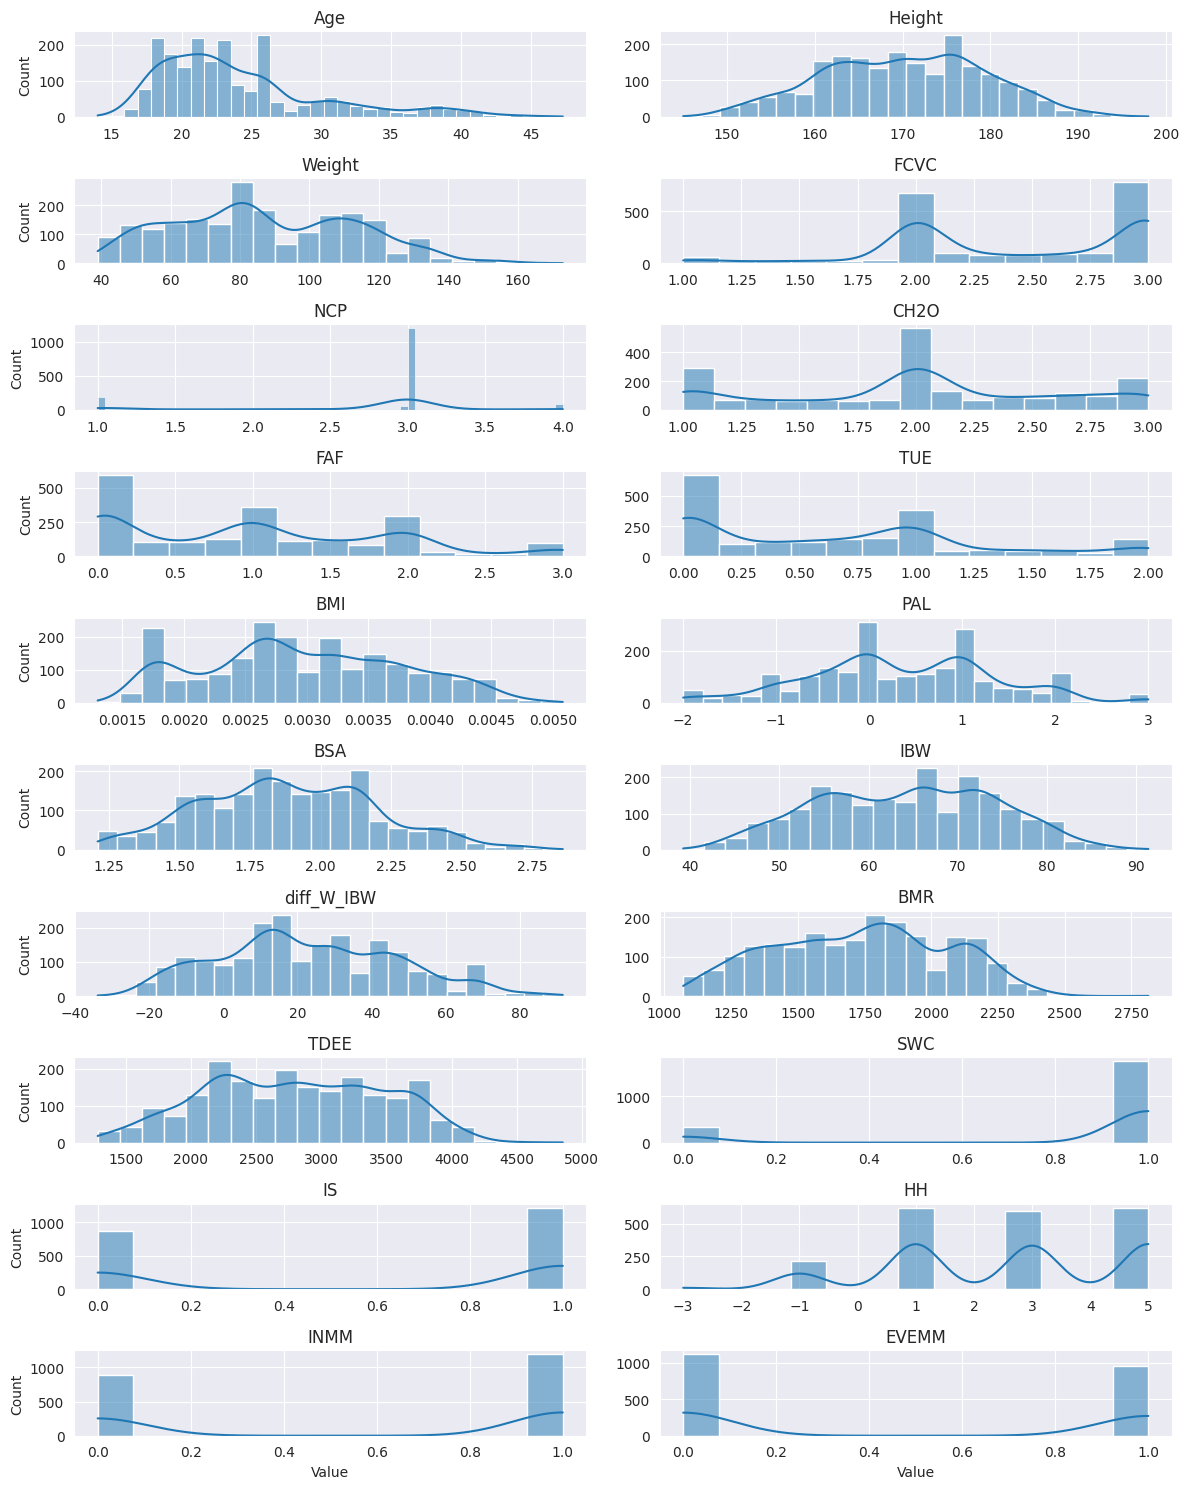

In [17]:
nrows = 10
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
r, c = 0, 0

fig.set_figwidth(12)
fig.set_figheight(15)

# plotting numerical columns distributions
numerical_columns = df.select_dtypes(exclude="object").columns.tolist()

for nc in numerical_columns:
    print(nc)
    if c == ncols:
        c = 0
        r += 1

    sns.histplot(
        data=df[nc],
        ax=axs[r, c],
        kde=True
    )

    axs[r, c].set_title(nc)
    axs[r, c].set_xlabel("")
    axs[r, c].set_ylabel("")

    if c == 0:
        axs[r, c].set_ylabel("Count")

    if (r == nrows - 1) or (r == nrows - 2 and c > 1):
        axs[r, c].set_xlabel("Value")

    c += 1

fig.tight_layout()
fig.show()

#### Transforming `Age` Column Into a Categorical Column

In [18]:
df["Age"] = pd.qcut(x=df["Age"], q=4, labels=["q1", "q2", "q3", "q4"])
df["Age"] = df["Age"].astype("object")
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,BSA,IBW,diff_W_IBW,BMR,TDEE,SWC,IS,HH,INMM,EVEMM
0,Female,q2,162.0,64.0,yes,no,2.0,3.0,Sometimes,no,...,1.608193,54.5,9.5,1386.5,1663.800,1,1,1,1,0
1,Female,q2,152.0,56.0,yes,no,3.0,3.0,Sometimes,yes,...,1.411812,45.5,10.5,1244.0,2363.600,1,0,3,1,1
2,Male,q3,180.0,77.0,yes,no,2.0,3.0,Sometimes,no,...,1.889914,75.2,1.8,1785.0,3079.125,1,0,3,1,0
3,Male,q4,180.0,87.0,no,no,3.0,3.0,Sometimes,no,...,1.979671,75.2,11.8,1865.0,3217.125,1,0,3,1,1
4,Male,q2,178.0,89.8,no,no,2.0,1.0,Sometimes,no,...,1.976075,73.4,16.4,1905.5,2286.600,1,1,1,0,1


#### Transforming `IS`, `SWC`, `EVEMM`, `INMM` into Categorical Columns

In [19]:
df["SWC"] = df["SWC"].astype("object")
df["IS"] = df["IS"].astype("object")
df["EVEMM"] = df["EVEMM"].astype("object")
df["INMM"] = df["INMM"].astype("object")
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,BSA,IBW,diff_W_IBW,BMR,TDEE,SWC,IS,HH,INMM,EVEMM
0,Female,q2,162.0,64.0,yes,no,2.0,3.0,Sometimes,no,...,1.608193,54.5,9.5,1386.5,1663.800,1,1,1,1,0
1,Female,q2,152.0,56.0,yes,no,3.0,3.0,Sometimes,yes,...,1.411812,45.5,10.5,1244.0,2363.600,1,0,3,1,1
2,Male,q3,180.0,77.0,yes,no,2.0,3.0,Sometimes,no,...,1.889914,75.2,1.8,1785.0,3079.125,1,0,3,1,0
3,Male,q4,180.0,87.0,no,no,3.0,3.0,Sometimes,no,...,1.979671,75.2,11.8,1865.0,3217.125,1,0,3,1,1
4,Male,q2,178.0,89.8,no,no,2.0,1.0,Sometimes,no,...,1.976075,73.4,16.4,1905.5,2286.600,1,1,1,0,1


#### Transforming `HH` Column Into a Categorical Column

In [20]:
df["HH"] = df["HH"].astype(int)
df["HH"] = pd.qcut(x=df["HH"], q=3, labels=["bad", "ok", "good"])
df["HH"] = df["HH"].astype("object")
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,BSA,IBW,diff_W_IBW,BMR,TDEE,SWC,IS,HH,INMM,EVEMM
0,Female,q2,162.0,64.0,yes,no,2.0,3.0,Sometimes,no,...,1.608193,54.5,9.5,1386.5,1663.800,1,1,bad,1,0
1,Female,q2,152.0,56.0,yes,no,3.0,3.0,Sometimes,yes,...,1.411812,45.5,10.5,1244.0,2363.600,1,0,ok,1,1
2,Male,q3,180.0,77.0,yes,no,2.0,3.0,Sometimes,no,...,1.889914,75.2,1.8,1785.0,3079.125,1,0,ok,1,0
3,Male,q4,180.0,87.0,no,no,3.0,3.0,Sometimes,no,...,1.979671,75.2,11.8,1865.0,3217.125,1,0,ok,1,1
4,Male,q2,178.0,89.8,no,no,2.0,1.0,Sometimes,no,...,1.976075,73.4,16.4,1905.5,2286.600,1,1,bad,0,1


#### Splitting the Data into Training and Validation Sets

In [21]:
X = df.drop(columns=["NObeyesdad"])
y = df["NObeyesdad"].values

X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.15,
    stratify=y,
    random_state=SEED
)

X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)

pprint(f"Train set shape: {X_train.shape} and {y_train.shape}")
pprint(f"Validation set shape: {X_valid.shape} and {y_valid.shape}")

'Train set shape: (1764, 28) and (1764,)'
'Validation set shape: (312, 28) and (312,)'


#### Transforming the Numerical Columns (Log Transformation)

In [22]:
numerical_columns = df.select_dtypes(exclude="object").columns.tolist()
epsilon = 1e-10

for nc in numerical_columns:
    if not nc in ["diff_W_IBW", "PAL"]:
        X_train[nc] = np.log1p(X_train[nc].values + epsilon)
        X_valid[nc] = np.log1p(X_valid[nc].values + epsilon)

#### Scaling the Numerical Columns

In [23]:
pprint("Training set skewness before scaling:")
pprint(X_train[numerical_columns].skew())
print()
pprint("Validation set skewness before scaling:")
pprint(X_valid[numerical_columns].skew())

'Training set skewness before scaling:'
Height       -0.154922
Weight       -0.294520
FCVC         -0.818356
NCP          -1.466571
CH2O         -0.454898
FAF          -0.080611
TUE           0.133246
BMI           0.142139
PAL           0.055608
BSA          -0.076925
IBW          -0.323769
diff_W_IBW    0.254831
BMR          -0.334841
TDEE         -0.483424
dtype: float64

'Validation set skewness before scaling:'
Height       -0.076724
Weight       -0.337723
FCVC         -0.904482
NCP          -1.575891
CH2O         -0.434562
FAF          -0.075592
TUE           0.087328
BMI           0.092417
PAL           0.158599
BSA          -0.100809
IBW          -0.269953
diff_W_IBW    0.210092
BMR          -0.322780
TDEE         -0.462272
dtype: float64


In [24]:
sc = StandardScaler()
scalers = {}

for nc in numerical_columns:
    X_train[nc] = sc.fit_transform(X_train[nc].values.reshape(-1, 1))
    X_valid[nc] = sc.transform(X_valid[nc].values.reshape(-1, 1))
    scalers[nc] = sc

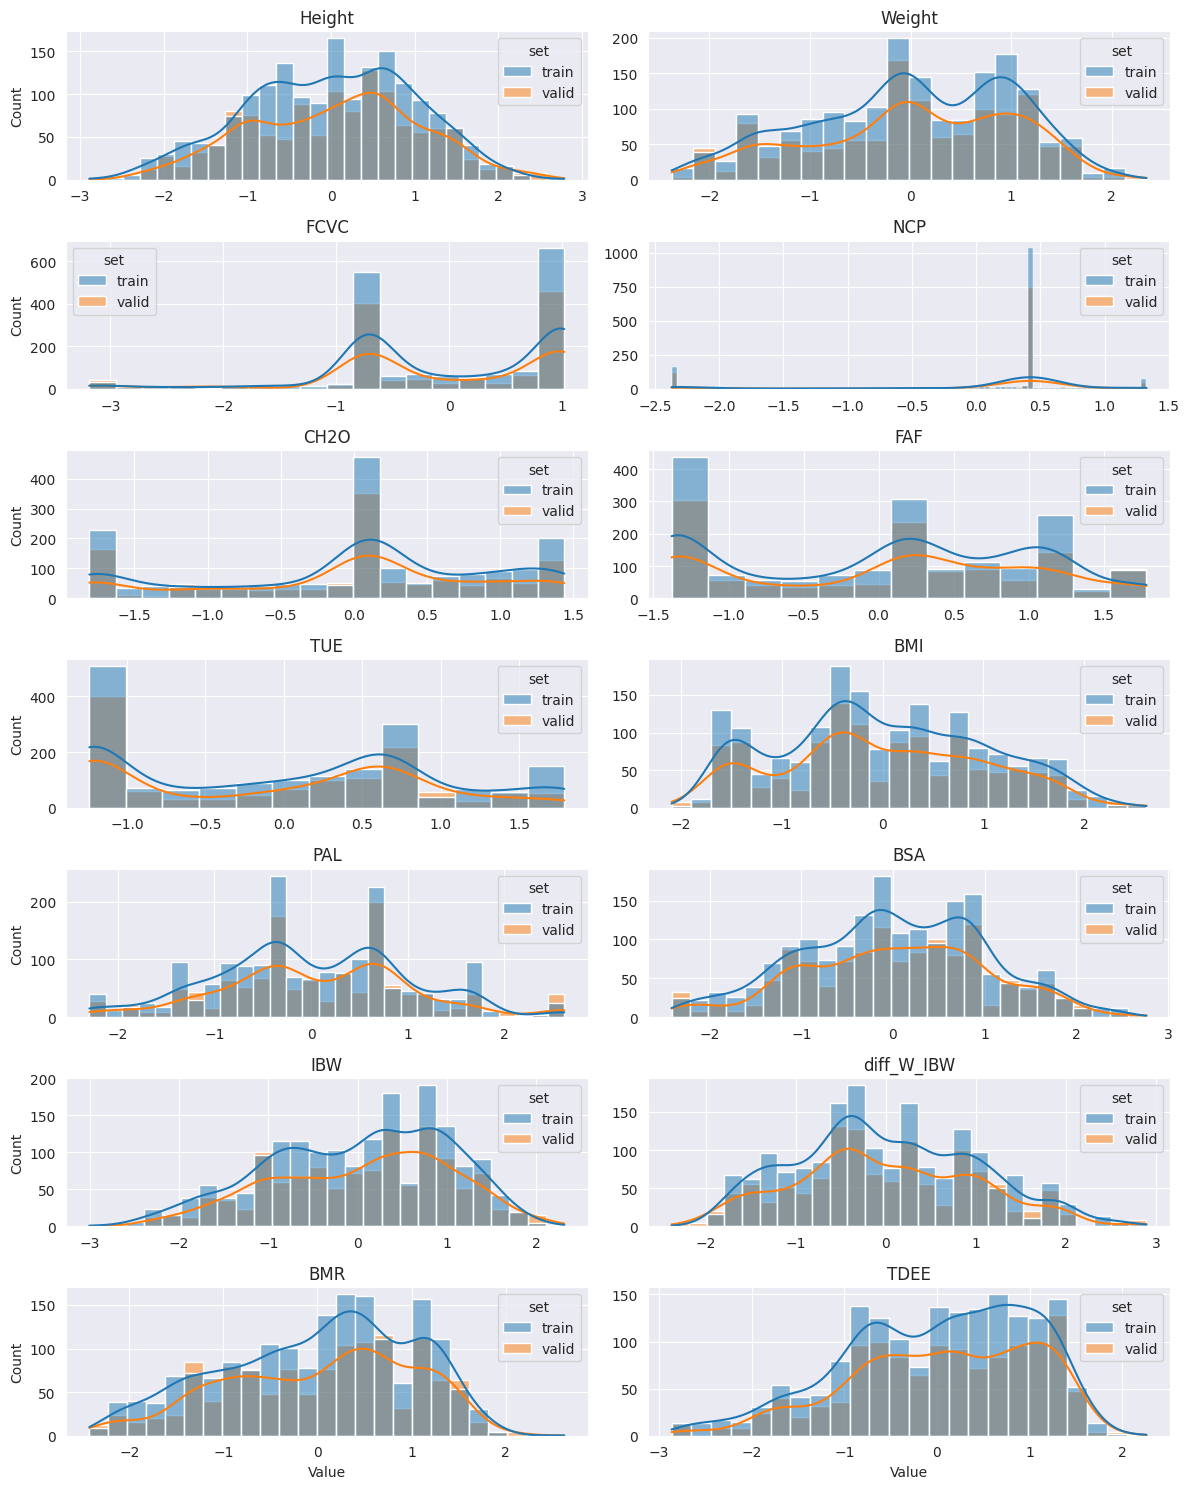

In [25]:
nrows = 7
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
r, c = 0, 0

fig.set_figwidth(12)
fig.set_figheight(15)

temp_train = X_train.copy()
temp_train["set"] = ["train"] * temp_train.shape[0]

temp_valid = X_valid.copy()
temp_valid["set"] = ["valid"] * temp_valid.shape[0]

temp = pd.concat(
    [temp_train, temp_valid, temp_valid, temp_valid, temp_valid],
    axis=0,
    ignore_index=True
)

for nc in numerical_columns:
    if c == ncols:
        c = 0
        r += 1

    sns.histplot(
        data=temp[[nc, "set"]],
        x=nc,
        hue="set",
        ax=axs[r, c],
        kde=True
    )

    axs[r, c].set_title(nc)
    axs[r, c].set_xlabel("")
    axs[r, c].set_ylabel("")

    if c == 0:
        axs[r, c].set_ylabel("Count")

    if (r == nrows - 1) or (r == nrows - 2 and c > 1):
        axs[r, c].set_xlabel("Value")

    c += 1

del temp, temp_train, temp_valid

fig.tight_layout()
fig.show()

In [26]:
pprint("Training set skewness after scaling:")
pprint(X_train[numerical_columns].skew())
print()
pprint("Validation set skewness after scaling:")
pprint(X_valid[numerical_columns].skew())

'Training set skewness after scaling:'
Height       -0.154922
Weight       -0.294520
FCVC         -0.818356
NCP          -1.466571
CH2O         -0.454898
FAF          -0.080611
TUE           0.133246
BMI           0.142139
PAL           0.055608
BSA          -0.076925
IBW          -0.323769
diff_W_IBW    0.254831
BMR          -0.334841
TDEE         -0.483424
dtype: float64

'Validation set skewness after scaling:'
Height       -0.076724
Weight       -0.337723
FCVC         -0.904482
NCP          -1.575891
CH2O         -0.434562
FAF          -0.075592
TUE           0.087328
BMI           0.092417
PAL           0.158599
BSA          -0.100809
IBW          -0.269953
diff_W_IBW    0.210092
BMR          -0.322780
TDEE         -0.462272
dtype: float64


#### Encoding the Categorical Columns

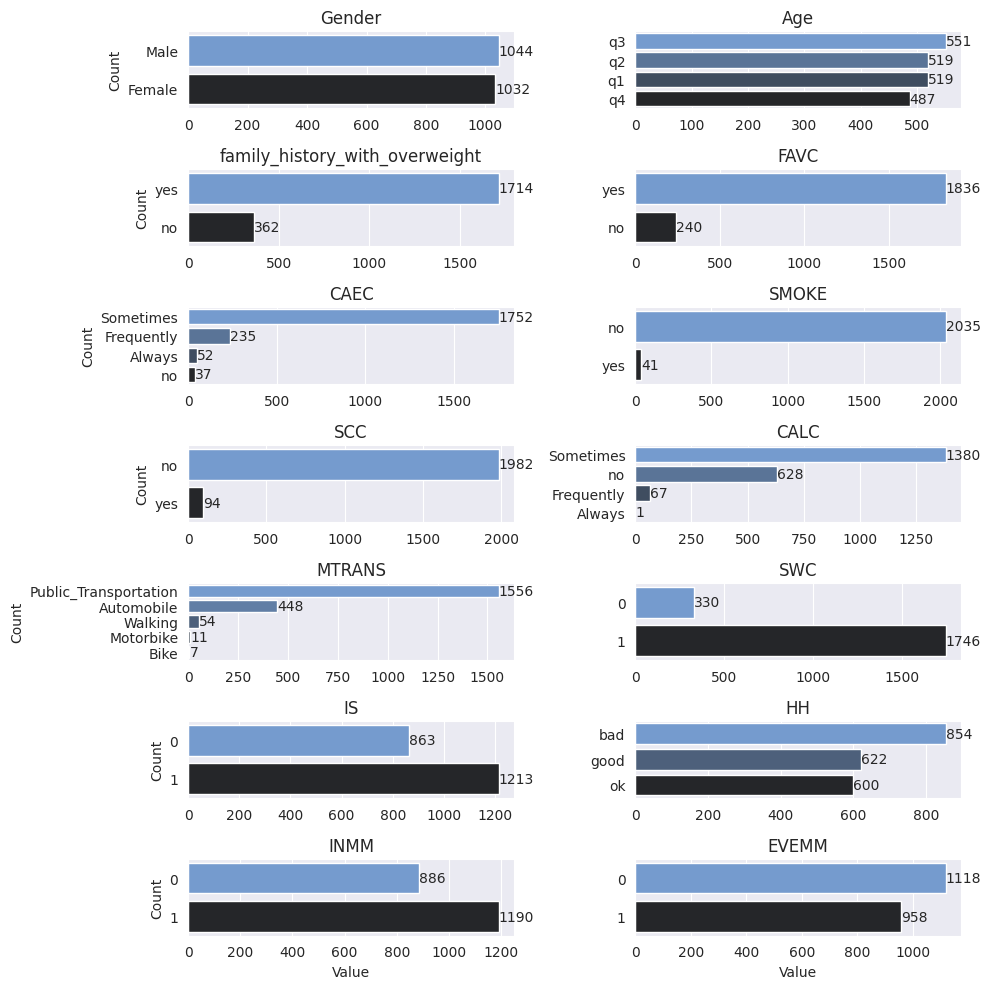

In [27]:
nrows = 7
ncols = 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
r, c = 0, 0

fig.set_figwidth(10)
fig.set_figheight(10)

# plotting categorical columns distributions
categorical_columns = df.select_dtypes(include="object").columns.tolist()
target_column = "NObeyesdad"
categorical_columns.remove(target_column)

for cc in categorical_columns:
    if c == ncols:
        c = 0
        r += 1

    temp = df[cc].value_counts().reset_index()
    temp.columns = ["Value", "Count"]

    sns.barplot(
        data=temp,
        y="Value",
        x="Count",
        palette=sns.dark_palette("#69d", reverse=True, n_colors=temp.shape[0]),
        ax=axs[r, c],
        orient="h"
    )

    for i in axs[r, c].containers:
        axs[r, c].bar_label(i,)

    axs[r, c].set_title(cc)
    axs[r, c].set_xlabel("")
    axs[r, c].set_ylabel("")

    if c == 0:
        axs[r, c].set_ylabel("Count")

    if (r == nrows - 1) or (r == nrows - 2 and c > 1):
        axs[r, c].set_xlabel("Value")

    c += 1

fig.tight_layout()
fig.show()

In [28]:
def custom_combiner(feature, category):
    return str(category)

new_train_df = pd.DataFrame()
new_valid_df = pd.DataFrame()

ohe = OneHotEncoder(
    drop="first",
    sparse_output=False,
    handle_unknown="infrequent_if_exist",
    min_frequency=20,
    feature_name_combiner=custom_combiner,
)

encoders = {}

for cc in categorical_columns:
    train_categorical_features = pd.DataFrame(
        ohe.fit_transform(X_train[cc].values.reshape(-1, 1)),
        columns=ohe.get_feature_names_out(),
    )
    train_categorical_features = train_categorical_features.add_prefix(cc + "_")
    new_train_df = pd.concat([new_train_df, train_categorical_features], axis=1)

    valid_categorical_features = pd.DataFrame(
        ohe.transform(X_valid[cc].values.reshape(-1, 1)),
        columns=ohe.get_feature_names_out(),
    )
    valid_categorical_features = valid_categorical_features.add_prefix(cc + "_")
    new_valid_df = pd.concat([new_valid_df, valid_categorical_features], axis=1)

    encoders[cc] = ohe

new_train_df = pd.concat([new_train_df, X_train.drop(columns=categorical_columns)], axis=1)
new_valid_df = pd.concat([new_valid_df, X_valid.drop(columns=categorical_columns)], axis=1)

X_train = new_train_df.values.copy()
X_valid = new_valid_df.values.copy()

#### Encoding the Labels

In [29]:
ohe_label = OneHotEncoder(
    drop=None,
    sparse_output=False
)

original_y_train = y_train.copy()
original_y_valid = y_valid.copy()

y_train = ohe_label.fit_transform(y_train.reshape(-1, 1))
y_valid = ohe_label.transform(y_valid.reshape(-1, 1))

In [30]:
pprint(f"Train set shape: {X_train.shape} and {y_train.shape}")
pprint(f"Validation set shape: {X_valid.shape} and {y_valid.shape}")

'Train set shape: (1764, 37) and (1764, 7)'
'Validation set shape: (312, 37) and (312, 7)'


### Saving the Artifacts

In [31]:
# saving the artifacts locally
os.makedirs(ARTIFACTS_OUTPUT_PATH, exist_ok=True)
os.makedirs(FEATURES_OUTPUT_PATH, exist_ok=True)

joblib.dump(scalers, os.path.join(ARTIFACTS_OUTPUT_PATH, "features_sc.pkl"))
joblib.dump(encoders, os.path.join(ARTIFACTS_OUTPUT_PATH, "features_ohe.pkl"))
joblib.dump(ohe_label, os.path.join(ARTIFACTS_OUTPUT_PATH, "label_ohe.pkl"))

joblib.dump(X_train, os.path.join(FEATURES_OUTPUT_PATH, "X_train.pkl"))
joblib.dump(y_train, os.path.join(FEATURES_OUTPUT_PATH, "y_train.pkl"))
joblib.dump(X_valid, os.path.join(FEATURES_OUTPUT_PATH, "X_valid.pkl"))
joblib.dump(y_valid, os.path.join(FEATURES_OUTPUT_PATH, "y_valid.pkl"))

['../models/features/y_valid.pkl']

In [32]:
# saving the preprocessed dataset locally
new_train_df["label"] = original_y_train
new_valid_df["label"] = original_y_valid

preprocessed_data = pd.concat([new_train_df, new_valid_df])
preprocessed_data.to_csv("../data/Preprocessed_ObesityDataSet.csv", index=False, sep=",")

In [33]:
# sending the artifacts to the aws s3 bucket
def upload_folder_s3(root_path: str):
    try:
        for path, _, files in os.walk(root_path):
            directory_name = path.split("/")[-2]
            for file in files:
                s3.upload_file(os.path.join(path, file), content["S3"], os.path.join(directory_name, file))

    except Exception as err:
        print(err)

if content["S3"] != "YOUR_S3_BUCKET_URL":
    artifacts_path = "../models/artifacts/"
    models_path = "../models/features/"

    if os.path.exists(artifacts_path):
        upload_folder_s3(artifacts_path)

    if os.path.exists(models_path):
        upload_folder_s3(models_path)

    # sending preprocessed dataset saved locally to the aws s3 bucket
    s3.upload_file("../data/Preprocessed_ObesityDataSet.csv", content["S3"], "Preprocessed_ObesityDataSet.csv")

    # removing downloaded dataset from local
    os.remove("../data/Original_ObesityDataSet.csv")
    os.remove("../data/Preprocessed_ObesityDataSet.csv")

    # removing the local artifacts and features
    shutil.rmtree("../models/artifacts/")
    shutil.rmtree("../models/features/")